#### MNIST Dataset

In [1]:
# Necessary imports
import pandas as pd
import numpy as np
from numpy import genfromtxt
#from pymfe.mfe import MFE
import csv
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.colors
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from keras.models import load_model
from scipy.io import arff
from io import StringIO
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import time
import random
from sklearn.model_selection import train_test_split 
from numpy.random import seed
seed(5)
import tensorflow as tf
tf.random.set_seed(7)
import random
random.seed(1)
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Lambda, Input, Dense, Layer
from tensorflow.keras.layers import BatchNormalization,LayerNormalization
from tensorflow.keras.losses import mse, binary_crossentropy,categorical_crossentropy,sparse_categorical_crossentropy
from tensorflow.keras.layers import Activation, Dense, Flatten 
from tensorflow.keras import backend as K
#from tensorflow.keras.utils import plot_model
#from tensorflow.keras.layers import Dropout
#from tensorflow.keras.layers import LeakyReLU

C:\Users\91948\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [2]:
# Model / data parameters
num_classes = 10
input_shape = (28, 28, 1)

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [3]:
x_train.shape


(60000, 28, 28, 1)

In [4]:
start_dimension = x_train.shape[1]*x_train.shape[1]
x_train = np.reshape(x_train, [-1, start_dimension])
x_test = np.reshape(x_test, [-1, start_dimension])
# parameters
input_shape = (start_dimension, )
intermediate_dim = 650
intermediate_dim1 = 300
batch_size = 64
latent_dim = 10
epochs = 200

In [5]:
def sampling(args):
    z_mean, z_log_var = args
    # K is the keras backend
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon


In [6]:
# Encoder model
inputs = keras.Input(shape=input_shape, name='encoder_input')
x = layers.Dense(intermediate_dim, activation='relu')(inputs)
x = LayerNormalization(axis=1)(x)
x = layers.Dense(intermediate_dim1, activation='relu')(x)
x = LayerNormalization(axis=1)(x)
z_mean = layers.Dense(latent_dim, name='z_mean')(x)
z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)
z = Lambda(sampling,
           output_shape=(latent_dim,), 
           name='z')([z_mean, z_log_var])

encoder = keras.Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()


Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 650)          510250      encoder_input[0][0]              
__________________________________________________________________________________________________
layer_normalization (LayerNorma (None, 650)          1300        dense[0][0]                      
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 300)          195300      layer_normalization[0][0]        
____________________________________________________________________________________________

In [7]:
# Decoder model
latent_inputs = keras.Input(shape=(latent_dim,), name='z_sampling')
x = layers.Dense(intermediate_dim1, activation='relu')(latent_inputs)
x = LayerNormalization(axis=1)(x)
x = layers.Dense(intermediate_dim, activation='relu')(x)
x = LayerNormalization(axis=1)(x)
outputs = layers.Dense(start_dimension, activation='sigmoid')(x)
decoder = keras.Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      [(None, 10)]              0         
_________________________________________________________________
dense_2 (Dense)              (None, 300)               3300      
_________________________________________________________________
layer_normalization_2 (Layer (None, 300)               600       
_________________________________________________________________
dense_3 (Dense)              (None, 650)               195650    
_________________________________________________________________
layer_normalization_3 (Layer (None, 650)               1300      
_________________________________________________________________
dense_4 (Dense)              (None, 784)               510384    
Total params: 711,234
Trainable params: 711,234
Non-trainable params: 0
_____________________________________________________

In [8]:
# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = keras.Model(inputs, outputs, name='vae_mlp')

In [9]:
Trn_imb_set = (4000,2000,1000,750,500,350,200,100,60,40)
imb_index = np.insert(np.cumsum(Trn_imb_set), 0, 0)

In [10]:
ximb_samples = np.zeros((np.sum(Trn_imb_set),x_train.shape[1]))

In [11]:
ximb_samples.shape

(9000, 784)

In [12]:
# Extract 0s, 1s, 2s, 3s and 4s classes for training the VAE

for i in range(num_classes):
    x_samples = x_train[y_train == i]
    x_s = x_samples[np.random.randint(0,x_samples.shape[0]-1, size=Trn_imb_set[i])]
    ximb_samples[imb_index[i]:imb_index[i+1],:] = x_s
    
yimb_samples = np.hstack([np.zeros((4000,)),np.ones((2000,)),np.ones((1000,))*2,np.ones((750,))*3,
                np.ones((500,))*4,np.ones((350,))*5,np.ones((200,))*6,np.ones((100,))*7,
                 np.ones((60,))*8,np.ones((40,))*9])
yimb_samples = yimb_samples.astype('uint8')
    

In [13]:
shuffled_indices = np.random.permutation((ximb_samples.shape[0])) #return a permutation of the indices

#print(f"shuffled indices: {shuffled_indices}")

ximb_samples = ximb_samples[shuffled_indices]

yimb_samples = yimb_samples[shuffled_indices].astype('uint8')

In [14]:
X_imtrain, X_imval, y_imtrain, y_imval = train_test_split(ximb_samples, yimb_samples, 
                                                    test_size=0.2, random_state=1)

### 100 Testing samples 

In [15]:
tst_samples = 100
xtst_samples = np.zeros((tst_samples*num_classes,x_test.shape[1]))
for i in range(num_classes):
    x_tst = x_test[y_test == i]
    x_tst = x_tst[np.random.randint(0,x_tst.shape[0]-1, size=tst_samples)]
    print(i*100,(i+1)*100)
    xtst_samples[i*100:(i+1)*100,:] = x_tst
    
ytst_samples = np.hstack([np.zeros((100,)),np.ones((100,)),np.ones((100,))*2,np.ones((100,))*3,
                np.ones((100,))*4,np.ones((100,))*5,np.ones((100,))*6,np.ones((100,))*7,
                 np.ones((100,))*8,np.ones((100,))*9])
ytst_samples = ytst_samples.astype('uint8')
    


0 100
100 200
200 300
300 400
400 500
500 600
600 700
700 800
800 900
900 1000


In [16]:
ytst_samples.shape

(1000,)

## VAE for imbalanced dataset

#### VAE code is adopted and modified from the following reference.
#### https://github.com/PacktPublishing/Advanced-Deep-Learning-with-Keras/blob/master/chapter8-vae/vae-mlp-mnist-8.1.1.py 

In [17]:
# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = keras.Model(inputs, outputs, name='vae_mlp')

In [18]:
if __name__ == '__main__':
    
    loss = 'bce'
    models = (encoder, decoder)
    data = (x_test, y_test)
    
    # VAE loss = mse_loss or xent_loss + kl_loss
    if loss == 'bce':
        reconstruction_loss = binary_crossentropy(inputs,
                                                  outputs)
    else:
        reconstruction_loss = mse(inputs, outputs)
        
    reconstruction_loss *= start_dimension
    kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    vae_loss = K.mean(reconstruction_loss + kl_loss)
    vae.add_loss(vae_loss)
    opt = keras.optimizers.Adam(lr=0.0005)
    vae.compile(optimizer=opt,)
    vae.summary()      
    vae.fit(X_imtrain,
            epochs=epochs,
            #verbose = 10,
            batch_size=batch_size,
            validation_data=(X_imval, None))
    

C:\Users\91948\Anaconda3\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Model: "vae_mlp"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 784)]        0                                            
__________________________________________________________________________________________________
encoder (Functional)            [(None, 10), (None,  713470      encoder_input[0][0]              
__________________________________________________________________________________________________
decoder (Functional)            (None, 784)          711234      encoder[1][2]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 650)          510250      encoder_input[0][0]              
____________________________________________________________________________________________

113/113 [==============================] - 4s 33ms/step - loss: 87.3363 - val_loss: 106.6055
Epoch 102/200
113/113 [==============================] - 4s 33ms/step - loss: 87.2122 - val_loss: 106.6243
Epoch 103/200
113/113 [==============================] - 4s 34ms/step - loss: 87.0583 - val_loss: 106.8598
Epoch 104/200
113/113 [==============================] - 4s 34ms/step - loss: 87.0779 - val_loss: 107.1647
Epoch 105/200
113/113 [==============================] - 4s 34ms/step - loss: 86.9462 - val_loss: 106.7567
Epoch 106/200
113/113 [==============================] - 4s 34ms/step - loss: 87.1246 - val_loss: 106.6909
Epoch 107/200
113/113 [==============================] - 4s 33ms/step - loss: 86.9049 - val_loss: 107.2661
Epoch 108/200
113/113 [==============================] - 4s 34ms/step - loss: 86.8268 - val_loss: 106.7499
Epoch 109/200
113/113 [==============================] - 4s 32ms/step - loss: 86.6956 - val_loss: 106.9150
Epoch 110/200
113/113 [============================

In [19]:
def latent_space_data(vae, data, labels):
    encoder, decoder = vae
    z_mean, _, _ = encoder.predict(data)
    return z_mean
latent_space_imb01234 = latent_space_data(models, ximb_samples, yimb_samples)
latent_space_imbTest = latent_space_data(models, xtst_samples,ytst_samples)

In [20]:
def metrics_aa_gm(ypred, ytrue):
    cm = confusion_matrix(ytrue, ypred)
    sum_classes = np.sum(cm, axis=1)
    true_pred = np.diagonal(cm)
    tp_rate = true_pred/sum_classes
    ACSA = np.mean(tp_rate)
    GM = np.prod(tp_rate)**(1/cm.shape[0])
    return ACSA, GM

In [21]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix

### MSPO

In [22]:
def SPOfn(latent_space_im,mino,majo,y_d):
       
    
    nTarget = np.sum(y_d == majo)


    posy = y_d == mino
    negy = y_d != mino
    
    minority_count = np.sum(posy)
    imbalance_factor = np.sqrt(nTarget//minority_count)
    P = latent_space_im[np.where(posy == True)[0],:]
    N = latent_space_im[np.where(negy == True)[0],:]

    #print(len(P),len(N))

    poscnt = P.shape[0]
    NumToGen = nTarget - poscnt
    Me  = np.mean((P),axis = 0)
    PCov = np.cov(P.T)
    print(NumToGen)
    [D,V] = np.linalg.eig(PCov)
    #d = [D[x,x] for x in range(D.shape[0])]
    if poscnt<= 100:
        d = D
    else:
        d = D
    #d = d.astype(np.float32)
    n = P.shape[1] #Feature dimension
    idx = d.argsort()[::-1]   
    d = d[idx]
    V = V[:,idx]
    #d = d[0:n+1]
    #v = V[:,n::-1]

    Ind = (d<= 5e-03)

    if np.sum(Ind) != 0:
        M = (list(Ind).index(True)+1)
    else:
        M = n

    PN = np.concatenate((P,N),axis=0)
    TCov = np.cov(PN.T)
    dT    = np.dot(V.T,np.dot(TCov, V))
    dT = [dT[x,x] for x in range(dT.shape[0])]

    #Modify the Eigen spectrum according to a 1-Parameter Model
    dMod  = np.zeros((n,1))
    Alpha = d[0]* d[M-1]*(M-1) /(d[0] - d[M-1]) #d[0]* d[M-1]*(M-1) /(d[0] - d[M-1])
    Beta  = ((M)*d[M-1] - d[0])/(d[0] - d[M-1])


    for i in range(n):
        if i<M-1:

            dMod[i] = d[i]
        else:
            dMod[i] = Alpha/(i+1+Beta)
            if dMod[i] > dT[i]:
                dMod[i] = dT[i]

    R = 1
    d = dMod
    print(d)
    
    ########################################
    
    import scipy
    from scipy.stats import multivariate_normal
    Rn = M
    Un = len(Me) - M
    Ptemp = P

    MuR = np.zeros((Rn,1)) #mlayer#
    SigmaR = np.identity((Rn)) #v_mat #

    MuU = np.zeros((Un,1))
    SigmaU = np.identity((Un))

    SampGen = np.zeros((int(NumToGen*R), len(Me)))
    SampSel = np.zeros((int(NumToGen), len(Me)))
    Prob    = np.zeros((int(NumToGen*R),1))

    cnt = 0
    DD = np.sqrt(d)
    MuR = MuR.reshape(MuR.shape[0],)
    MuU = MuU.reshape(MuU.shape[0],)

    while cnt < int(R*NumToGen):

        aR =  np.random.multivariate_normal(MuR.T, SigmaR, 1)
        #print(aR)
        #scipy.stats.multivariate_normal(MuR.T, SigmaR, 1)
        tp = multivariate_normal.pdf(aR, MuR, SigmaR) #aR.pdf(1)
        #print(tp)

        if Un > 0:
            aU = np.random.multivariate_normal(MuU, SigmaU, 1)
            #scipy.stats.multivariate_normal(MuU, SigmaU, 1)
            a = np.multiply(np.concatenate((aR,aU),axis=1).T,DD)   #The vector in Eigen transformed domain;
        else:
            a = np.multiply(aR.T,DD)
            #print(a)

        x = np.dot(a.T,V.T)+ Me
        #print(x)
        #pdb.set_trace()
        PDist = np.sqrt(np.sum(np.square((x-P)),axis=1))
        NDist = np.sqrt(np.sum(np.square((x-N)),axis=1))

        [tmp,ind]  = [np.min(NDist),np.argmin(NDist)]

        if np.min(PDist) < tmp:
            PPDist = np.sqrt(np.sum(np.square((N[ind,:]-P)),axis=1))
            if tmp >= np.min(PPDist) and tmp <= np.max(PPDist):
                SampGen[cnt,:] = x
                Prob[cnt,0] = tp  
                cnt+=1
                Ptemp = np.concatenate((Ptemp,SampGen),axis =0)

    for i in range(NumToGen):
        [tmp,ind]  = [np.min(Prob),np.argmin(Prob)]
        Prob[ind] =  np.inf
        SampSel[i,:] = SampGen[ind,:]

    Ynew = SampSel #np.concatenate((SampSel,P),axis = 0)
    #Total = np.concatenate((Ynew,N),axis = 0)
    
    return Ynew


In [23]:
Total = latent_space_imb01234#[yimb_samples == 0]
y_tot = yimb_samples #np.zeros((np.sum(yimb_samples == 0),))
for i in range(10):
    Newsamples = SPOfn(Total,i,0,y_tot)
    y_tot = np.concatenate((y_tot,np.ones((Newsamples.shape[0],))*i),axis = 0)
    Total = np.concatenate((Total,Newsamples),axis = 0)

0
[[1.88881983]
 [1.43777872]
 [1.04897458]
 [0.9701716 ]
 [0.7896824 ]
 [0.7325179 ]
 [0.66413698]
 [0.53401408]
 [0.4838099 ]
 [0.28691936]]
2000
[[2.18076576]
 [1.01942655]
 [0.82946112]
 [0.6849477 ]
 [0.56481435]
 [0.4362404 ]
 [0.24132991]
 [0.14365088]
 [0.10586861]
 [0.07003895]]
3000
[[1.49074955]
 [1.38503044]
 [1.17037965]
 [1.09914652]
 [0.74268777]
 [0.5488784 ]
 [0.48155598]
 [0.41742101]
 [0.28485464]
 [0.21340421]]
3250
[[1.66984851]
 [1.37677467]
 [0.99033701]
 [0.88688072]
 [0.55568588]
 [0.52829776]
 [0.36992364]
 [0.3361327 ]
 [0.32254913]
 [0.15453268]]
3500
[[1.19801713]
 [0.94504756]
 [0.69576778]
 [0.56561623]
 [0.50279083]
 [0.41437411]
 [0.33151377]
 [0.29133987]
 [0.17057402]
 [0.11172274]]
3650
[[2.56922509]
 [1.38855256]
 [1.09682367]
 [0.76577902]
 [0.63899368]
 [0.52394163]
 [0.41289191]
 [0.31145923]
 [0.18567774]
 [0.10160499]]
3800
[[1.51619986]
 [0.89138946]
 [0.710014  ]
 [0.56709091]
 [0.47402968]
 [0.36154294]
 [0.2860907 ]
 [0.15606041]
 [0.133348

In [24]:
Total.shape

(40000, 10)

### MLP on MSPO latent space

0.898
              precision    recall  f1-score   support

     class 0       0.99      0.94      0.97       105
     class 1       0.99      0.95      0.97       104
     class 2       0.96      0.86      0.91       112
     class 3       0.90      0.83      0.86       109
     class 4       1.00      0.87      0.93       115
     class 5       0.89      0.83      0.86       107
     class 6       0.90      0.96      0.93        94
     class 7       0.92      0.93      0.92        99
     class 8       0.63      0.95      0.76        66
     class 9       0.80      0.90      0.85        89

    accuracy                           0.90      1000
   macro avg       0.90      0.90      0.90      1000
weighted avg       0.91      0.90      0.90      1000



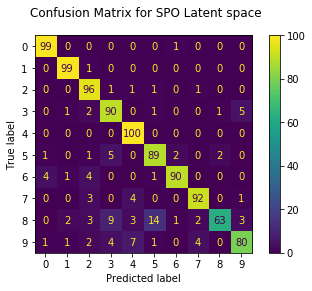

In [25]:
X_train = (Total)
y_train = (y_tot)
X_test = (latent_space_imbTest)
y_test = (ytst_samples)

mm_X = MinMaxScaler(feature_range=(0,1))
X_trainscaled= mm_X.fit_transform(X_train)
X_testscaled= mm_X.transform(X_test)

clf = MLPClassifier(solver='adam',shuffle = True, hidden_layer_sizes=(16,160,30,22,),
                    activation="relu",random_state=1,max_iter = 5000,
                    learning_rate_init=0.00367, batch_size = 200,warm_start=True,
                    learning_rate = 'constant',beta_1 = 0.9,beta_2 = 0.999)
#16,128,32,20 - 89.6 % accuracy 0.367
#24,256,32,16 - 88% accu

clf.fit(X_trainscaled, y_train)
y_pred=clf.predict(X_testscaled)
print(clf.score(X_testscaled, y_test))

fig=plot_confusion_matrix(clf, X_testscaled, y_test,display_labels=["0",'1','2','3','4','5','6','7','8','9'])
fig.figure_.suptitle("Confusion Matrix for SPO Latent space")

target_names = ['class 0', 'class 1','class 2','class 3','class 4','class 5','class 6','class 7','class 8','class 9']
print(classification_report( y_pred,y_test, target_names=target_names))

In [26]:
# Evaluation metrics
acsa, gm = metrics_aa_gm(y_pred, y_test) 
print( 'ACSA =',acsa,'GM=', gm,)

ACSA = 0.898 GM= 0.8907657317916466


#### Cross validation

In [27]:
kf = KFold(n_splits=10,)

In [28]:
for train_indices, test_indices in kf.split((X_trainscaled)):
    clf.fit(X_trainscaled[train_indices], y_train[train_indices])
    print(clf.score(X_testscaled, y_test))
    
    y_pred=clf.predict(X_testscaled)
    acsa, gm = metrics_aa_gm(y_pred, y_test) 
    print (acsa, gm,)

0.892
0.8920000000000001 0.8853232521847746
0.892
0.892 0.8840900270196411
0.899
0.8989999999999998 0.8949933855015947
0.87
0.8699999999999999 0.8607263263901768
0.875
0.875 0.8674860936783766
0.868
0.868 0.8592834955737964
0.863
0.8629999999999999 0.8517011289188221
0.875
0.875 0.868340627791707
0.878
0.8779999999999999 0.8692708662800451
0.862
0.8620000000000001 0.8407268896762957


#### Generate images

In [29]:
encoder, decoder = models
Tiles = np.zeros((280,280))

In [30]:
for i in range(10):
    for j in range(10):
        index =random.randint(2000,3999)
        points9 = Total[y_tot==j]
        inp = np.reshape(points9[index], [-1, 10])
        I_decoded = decoder.predict(inp)
        Tiles[i*28:(i+1)*28,j*28:(j+1)*28] = np.reshape(I_decoded,[28,28])

(-0.5, 279.5, 279.5, -0.5)

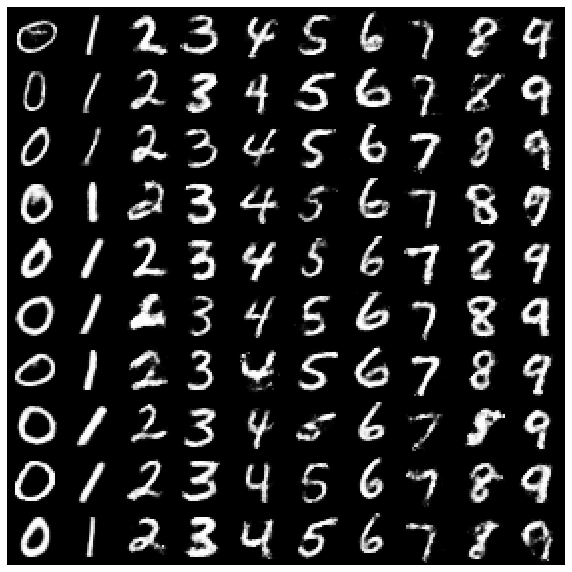

In [31]:
plt.figure(figsize=(10,18))
plt.imshow(Tiles,cmap='gray')
plt.axis('off')
#plt.savefig("mnist_generatedimages.png", bbox_inches='tight')

In [32]:
from sklearn.metrics import silhouette_samples, silhouette_score

In [33]:
score = silhouette_score(Total, y_tot, metric='l2')
print(score)

0.13061393860074602


In [34]:
import time
from sklearn.manifold import TSNE
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=8000)
#z_mean1 = z_mean.detach().numpy()
tsne_mspo_latent = tsne.fit_transform(Total)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 40000 samples in 0.118s...
[t-SNE] Computed neighbors for 40000 samples in 20.959s...
[t-SNE] Computed conditional probabilities for sample 1000 / 40000
[t-SNE] Computed conditional probabilities for sample 2000 / 40000
[t-SNE] Computed conditional probabilities for sample 3000 / 40000
[t-SNE] Computed conditional probabilities for sample 4000 / 40000
[t-SNE] Computed conditional probabilities for sample 5000 / 40000
[t-SNE] Computed conditional probabilities for sample 6000 / 40000
[t-SNE] Computed conditional probabilities for sample 7000 / 40000
[t-SNE] Computed conditional probabilities for sample 8000 / 40000
[t-SNE] Computed conditional probabilities for sample 9000 / 40000
[t-SNE] Computed conditional probabilities for sample 10000 / 40000
[t-SNE] Computed conditional probabilities for sample 11000 / 40000
[t-SNE] Computed conditional probabilities for sample 12000 / 40000
[t-SNE] Computed conditional probabilities for s

(9000,)


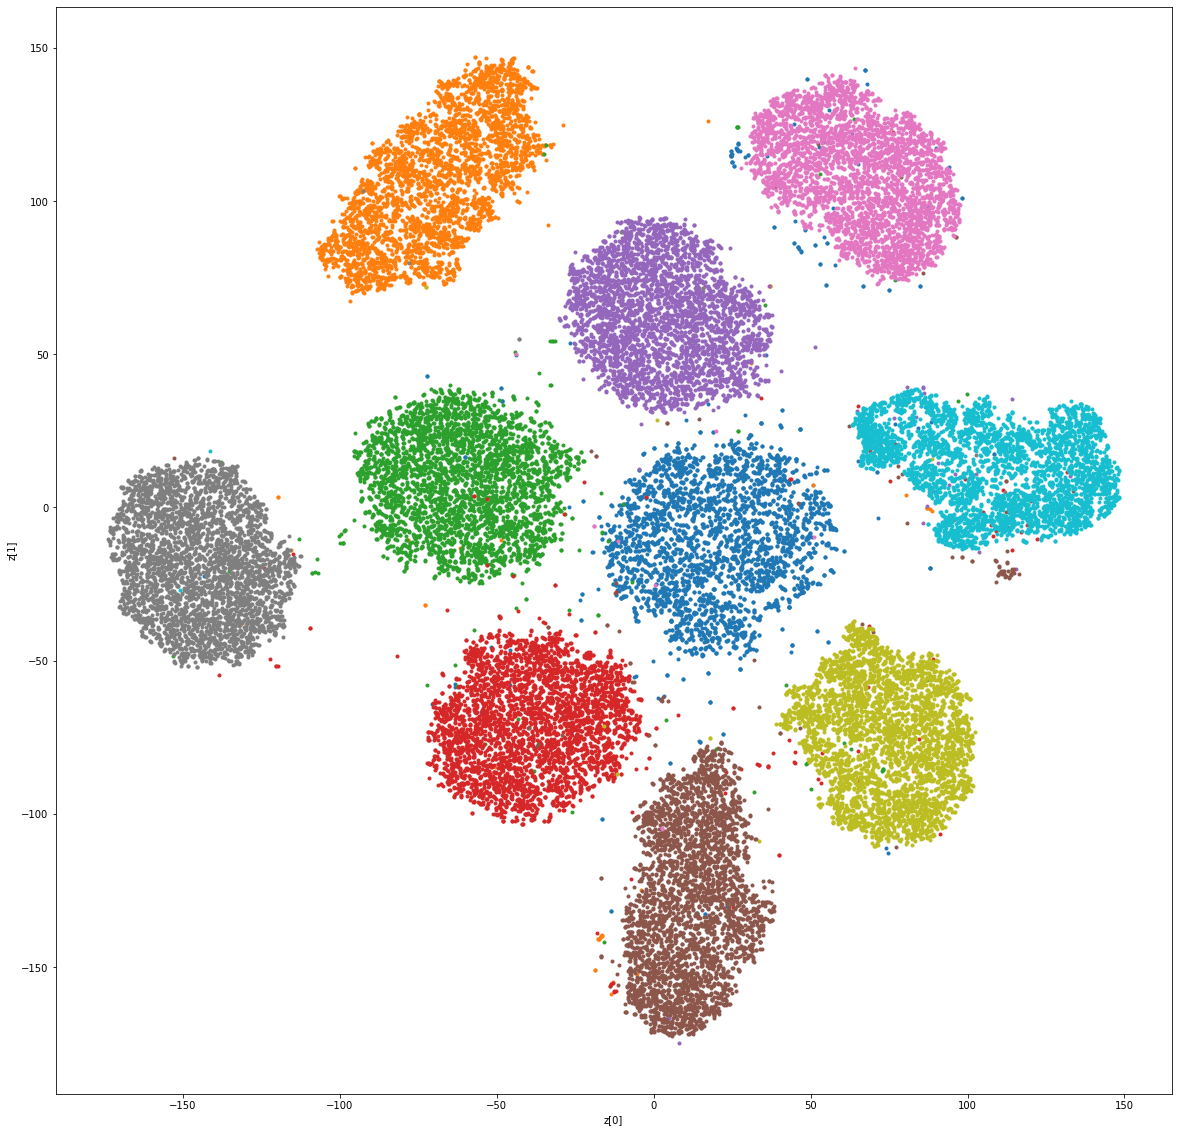

In [35]:
    plt.figure(figsize= (20, 20))
    
    #colors = ["#9A0EE0",'b','#FF4500','g','r','#808080','y','k','m','#00FFFF']
    #cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["r","b"])
    print(yimb_samples.shape)
    for i in range(0,10):
        points = tsne_mspo_latent[np.where(y_tot ==i)[0]]
        #print(points.shape)
        p0 = plt.scatter(points[:, 0], points[:, 1], marker=('.'),)
        
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    #plt.legend((p0,p1,p2,p3,p4,p5,p6,p7,p8,p9),('0','1','2','3','4','5','6','7','8','9'), loc='upper right')
    plt.savefig('latent_mspo1.png')


#### SMOTE

In [36]:
from imblearn.over_sampling import SMOTE
from collections import Counter

In [37]:
oversample = SMOTE()
X_sm, y_sm = oversample.fit_resample(latent_space_imb01234, yimb_samples)

In [65]:
score_sm = silhouette_score(X_sm, y_sm, metric='l2')
print("Silhouette score for VAE+SMOTE oversmpled dataset =",score_sm)

Silhouette score for VAE+SMOTE oversmpled dataset = 0.083003104


0.883
              precision    recall  f1-score   support

     class 0       0.97      0.95      0.96       102
     class 1       1.00      0.94      0.97       106
     class 2       0.95      0.90      0.92       106
     class 3       0.89      0.86      0.88       103
     class 4       0.98      0.79      0.87       124
     class 5       0.91      0.81      0.85       113
     class 6       0.89      0.96      0.92        93
     class 7       0.88      0.91      0.89        97
     class 8       0.65      0.88      0.75        74
     class 9       0.71      0.87      0.78        82

    accuracy                           0.88      1000
   macro avg       0.88      0.89      0.88      1000
weighted avg       0.90      0.88      0.89      1000



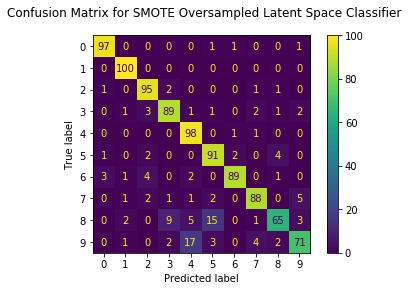

In [70]:
X_train = (X_sm)
y_train = (y_sm)
X_test = (latent_space_imbTest)
y_test = (ytst_samples)

mm_X = MinMaxScaler(feature_range=(0,1))
X_trainscaled= mm_X.fit_transform(X_train)
X_testscaled= mm_X.transform(X_test)

clf = MLPClassifier(solver='adam',shuffle = True, hidden_layer_sizes=(16,128,30,22,),
                    activation="relu",random_state=1,max_iter = 5000,
                    learning_rate_init=0.00367, batch_size = 200,warm_start=True,
                    learning_rate = 'constant',beta_1 = 0.9,beta_2 = 0.999)
#16,128,32,20 - 89.6 % accuracy 0.367
#24,256,32,16 - 88% accu

clf.fit(X_trainscaled, y_train)
y_pred=clf.predict(X_testscaled)
print(clf.score(X_testscaled, y_test))

fig=plot_confusion_matrix(clf, X_testscaled, y_test,display_labels=["0",'1','2','3','4','5','6','7','8','9'])
fig.figure_.suptitle("Confusion Matrix for SMOTE Oversampled Latent Space Classifier")

target_names = ['class 0', 'class 1','class 2','class 3','class 4','class 5','class 6','class 7','class 8','class 9']
print(classification_report( y_pred,y_test, target_names=target_names))

In [71]:
# Evaluation metrics
acsa, gm = metrics_aa_gm(y_pred, y_test) 
print('No oversampling - VAE+SMOTE+MLP')
print( 'ACSA =',acsa,'GM=', gm,)

No oversampling - VAE+MLP
ACSA = 0.8829999999999998 GM= 0.8754265621864562


#### ADASYN

In [40]:
from imblearn.over_sampling import ADASYN 

In [41]:
oversample = ADASYN()
X_adsn, y_adsn = oversample.fit_resample(latent_space_imb01234, yimb_samples)

In [66]:
score_adsn = silhouette_score(X_adsn, y_adsn, metric='l2')
print("Silhouette score for VAE+ADASYN oversampled data =",score_adsn)

Silhouette score for VAE+ADASYN oversampled data = 0.02076412


0.861
              precision    recall  f1-score   support

     class 0       1.00      0.83      0.90       121
     class 1       0.99      0.93      0.96       106
     class 2       0.93      0.85      0.89       110
     class 3       0.88      0.86      0.87       102
     class 4       0.97      0.72      0.83       135
     class 5       0.85      0.83      0.84       102
     class 6       0.84      0.99      0.91        85
     class 7       0.84      0.90      0.87        93
     class 8       0.66      0.90      0.76        73
     class 9       0.65      0.89      0.75        73

    accuracy                           0.86      1000
   macro avg       0.86      0.87      0.86      1000
weighted avg       0.88      0.86      0.86      1000



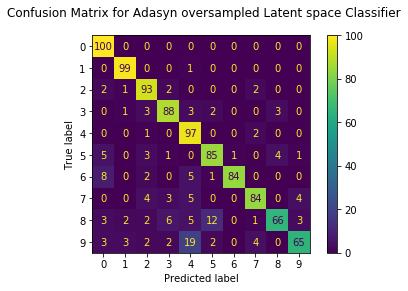

In [72]:
X_train = (X_adsn)
y_train = (y_adsn)
X_test = (latent_space_imbTest)
y_test = (ytst_samples)

mm_X = MinMaxScaler(feature_range=(0,1))
X_trainscaled= mm_X.fit_transform(X_train)
X_testscaled= mm_X.transform(X_test)

clf = MLPClassifier(solver='adam',shuffle = True, hidden_layer_sizes=(16,128,30,22,),
                    activation="relu",random_state=1,max_iter = 5000,
                    learning_rate_init=0.00367, batch_size = 200,warm_start=True,
                    learning_rate = 'constant',beta_1 = 0.9,beta_2 = 0.999)
#16,128,32,20 - 89.6 % accuracy 0.367
#24,256,32,16 - 88% accu

clf.fit(X_trainscaled, y_train)
y_pred=clf.predict(X_testscaled)
print(clf.score(X_testscaled, y_test))

fig=plot_confusion_matrix(clf, X_testscaled, y_test,display_labels=["0",'1','2','3','4','5','6','7','8','9'])
fig.figure_.suptitle("Confusion Matrix for Adasyn oversampled Latent space Classifier")

target_names = ['class 0', 'class 1','class 2','class 3','class 4','class 5','class 6','class 7','class 8','class 9']
print(classification_report( y_pred,y_test, target_names=target_names))

In [73]:
# Evaluation metrics
acsa, gm = metrics_aa_gm(y_pred, y_test) 
print('No oversampling - VAE+ADASYN+MLP')
print( 'ACSA =',acsa,'GM=', gm,)

No oversampling - VAE+ADASYN+MLP
ACSA = 0.861 GM= 0.8522769322172975


#### Random oversampling

In [44]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
X_rand, y_rand = ros.fit_resample(latent_space_imb01234, yimb_samples)

In [67]:
score_rand = silhouette_score(X_rand, y_rand, metric='l2')
print("Silhouette score for VAE+Random oversampled data =",score_rand)

Silhouette score for VAE+Random oversampled data = 0.06512854


0.866
              precision    recall  f1-score   support

     class 0       0.99      0.93      0.96       107
     class 1       1.00      0.91      0.95       110
     class 2       0.96      0.88      0.92       109
     class 3       0.87      0.85      0.86       102
     class 4       0.96      0.76      0.85       126
     class 5       0.92      0.79      0.85       117
     class 6       0.91      0.95      0.93        96
     class 7       0.82      0.91      0.86        90
     class 8       0.57      0.92      0.70        62
     class 9       0.66      0.81      0.73        81

    accuracy                           0.87      1000
   macro avg       0.87      0.87      0.86      1000
weighted avg       0.89      0.87      0.87      1000



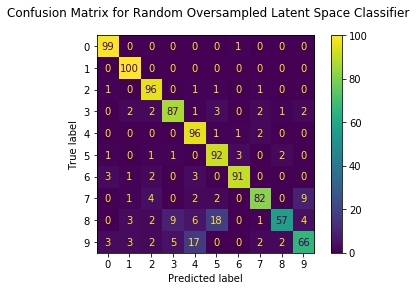

In [74]:
X_train = (X_rand)
y_train = (y_rand)
X_test = (latent_space_imbTest)
y_test = (ytst_samples)

mm_X = MinMaxScaler(feature_range=(0,1))
X_trainscaled= mm_X.fit_transform(X_train)
X_testscaled= mm_X.transform(X_test)

clf = MLPClassifier(solver='adam',shuffle = True, hidden_layer_sizes=(16,160,30,22,),
                    activation="relu",random_state=1,max_iter = 5000,
                    learning_rate_init=0.00367, batch_size = 200,warm_start=True,
                    learning_rate = 'constant',beta_1 = 0.9,beta_2 = 0.999)
#16,128,32,20 - 89.6 % accuracy 0.367
#24,256,32,16 - 88% accu

clf.fit(X_trainscaled, y_train)
y_pred=clf.predict(X_testscaled)
print(clf.score(X_testscaled, y_test))

fig=plot_confusion_matrix(clf, X_testscaled, y_test,display_labels=["0",'1','2','3','4','5','6','7','8','9'])
fig.figure_.suptitle("Confusion Matrix for Random Oversampled Latent Space Classifier")

target_names = ['class 0', 'class 1','class 2','class 3','class 4','class 5','class 6','class 7','class 8','class 9']
print(classification_report( y_pred,y_test, target_names=target_names))

In [75]:
# Evaluation metrics
acsa, gm = metrics_aa_gm(y_pred, y_test) 
print('No oversampling - VAE+RANDOM+MLP')
print( 'ACSA =',acsa,'GM=', gm,)

No oversampling - VAE+RANDOM+MLP
ACSA = 0.866 GM= 0.853445666724547


#### Borderline - SMOTE

In [49]:
from imblearn.over_sampling import BorderlineSMOTE
X_bos, y_bos = BorderlineSMOTE().fit_resample(latent_space_imb01234, yimb_samples)

In [68]:
score_bos = silhouette_score(X_bos, y_bos, metric='l2')
print("Silhouette score for VAE+Borderline SMOTE oversampled data =",score_bos)

Silhouette score for VAE+Borderline SMOTE oversampled data = 0.020233622


0.866
              precision    recall  f1-score   support

     class 0       1.00      0.85      0.92       118
     class 1       1.00      0.93      0.97       107
     class 2       0.95      0.82      0.88       116
     class 3       0.87      0.77      0.82       113
     class 4       0.97      0.84      0.90       116
     class 5       0.84      0.86      0.85        98
     class 6       0.92      0.95      0.93        97
     class 7       0.82      0.88      0.85        93
     class 8       0.61      0.91      0.73        67
     class 9       0.68      0.91      0.78        75

    accuracy                           0.87      1000
   macro avg       0.87      0.87      0.86      1000
weighted avg       0.89      0.87      0.87      1000



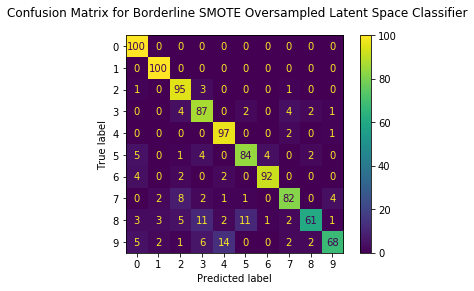

In [76]:
X_train = (X_bos)
y_train = (y_bos)
X_test = (latent_space_imbTest)
y_test = (ytst_samples)

mm_X = MinMaxScaler(feature_range=(0,1))
X_trainscaled= mm_X.fit_transform(X_train)
X_testscaled= mm_X.transform(X_test)

clf = MLPClassifier(solver='adam',shuffle = True, hidden_layer_sizes=(16,136,30,22,),
                    activation="relu",random_state=1,max_iter = 5000,
                    learning_rate_init=0.00367, batch_size = 200,warm_start=True,
                    learning_rate = 'constant',beta_1 = 0.9,beta_2 = 0.999)
#16,128,32,20 - 89.6 % accuracy 0.367
#24,256,32,16 - 88% accu

clf.fit(X_trainscaled, y_train)
y_pred=clf.predict(X_testscaled)
print(clf.score(X_testscaled, y_test))

fig=plot_confusion_matrix(clf, X_testscaled, y_test,display_labels=["0",'1','2','3','4','5','6','7','8','9'])
fig.figure_.suptitle("Confusion Matrix for Borderline SMOTE Oversampled Latent Space Classifier")

target_names = ['class 0', 'class 1','class 2','class 3','class 4','class 5','class 6','class 7','class 8','class 9']
print(classification_report( y_pred,y_test, target_names=target_names))

In [77]:
# Evaluation metrics
acsa, gm = metrics_aa_gm(y_pred, y_test) 
print('No oversampling - VAE+BoS+MLP')
print( 'ACSA =',acsa,'GM=', gm,)

No oversampling - VAE+BoS+MLP
ACSA = 0.866 GM= 0.855802263025228


#### No oversampling

In [69]:
score_noOS = silhouette_score(latent_space_imb01234, yimb_samples, metric='l2')
print("Silhouette score for VAE latent data =",score_noOS)

Silhouette score for VAE latent data = 0.015684612


0.855
              precision    recall  f1-score   support

     class 0       0.99      0.88      0.93       113
     class 1       0.99      0.94      0.97       105
     class 2       0.96      0.88      0.92       109
     class 3       0.91      0.76      0.83       120
     class 4       0.98      0.75      0.85       130
     class 5       0.91      0.78      0.84       116
     class 6       0.86      0.96      0.91        90
     class 7       0.75      0.93      0.83        81
     class 8       0.56      0.95      0.70        59
     class 9       0.64      0.83      0.72        77

    accuracy                           0.85      1000
   macro avg       0.86      0.87      0.85      1000
weighted avg       0.88      0.85      0.86      1000



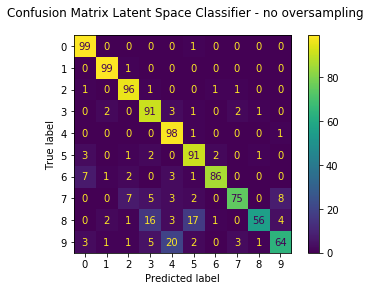

In [60]:
X_train = (latent_space_imb01234)
y_train = (yimb_samples)
X_test = (latent_space_imbTest)
y_test = (ytst_samples)

mm_X = MinMaxScaler(feature_range=(0,1))
X_trainscaled= mm_X.fit_transform(X_train)
X_testscaled= mm_X.transform(X_test)

clf = MLPClassifier(solver='adam',shuffle = True, hidden_layer_sizes=(16,148,30,22,),
                    activation="relu",random_state=1,max_iter = 5000,
                    learning_rate_init=0.00367, batch_size = 200,warm_start=True,
                    learning_rate = 'constant',beta_1 = 0.9,beta_2 = 0.999)
#16,128,32,20 - 89.6 % accuracy 0.367
#24,256,32,16 - 88% accu

clf.fit(X_trainscaled, y_train)
y_pred=clf.predict(X_testscaled)
print(clf.score(X_testscaled, y_test))

fig=plot_confusion_matrix(clf, X_testscaled, y_test,display_labels=["0",'1','2','3','4','5','6','7','8','9'])
fig.figure_.suptitle("Confusion Matrix Latent Space Classifier - no oversampling")

target_names = ['class 0', 'class 1','class 2','class 3','class 4','class 5','class 6','class 7','class 8','class 9']
print(classification_report( y_pred,y_test, target_names=target_names))

In [61]:
# Evaluation metrics
acsa, gm = metrics_aa_gm(y_pred, y_test) 
print('No oversampling - VAE+MLP')
print( 'ACSA =',acsa,'GM=', gm,)

No oversampling - VAE+MLP
ACSA = 0.8550000000000001 GM= 0.8407711864155258
